In [1]:
import sqlite3
import pandas as pd
import spacy
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from gensim import corpora
import gensim
import pickle

unable to import 'smart_open.gcs', disabling that module


In [23]:
pd.set_option('display.max_colwidth', None)
nlp = spacy.load('nl_core_news_sm')

## Discover the data

In [3]:
con = sqlite3.connect("corona-data.db")
df = pd.read_sql_query("SELECT * FROM initiatives", con, index_col = 'id')

## NLP preprocessing

In [6]:
def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
    doc = nlp(texts)
    output= [token.lemma_ for token in doc if token.pos_ in tags]
    return output

In [8]:
zoekwoorden = {
'vraag': ["demand", "vraag", "hulpvraag"],
'aanbod' : ["aangeboden", "hulpaanbod", "aanbod"]
}
    
def check_regex(x):
    x = re.sub( '[^a-z0-9]', ' ', str(x).lower())
    antwoord = []
    for label, keywords in zoekwoorden.items():
        li = [label for w in x.split() if w in keywords]
        if len(li) != 0:
            antwoord.append(li[0])
    return " ".join(antwoord)

In [9]:
def startpipeline(dataf):
    return dataf.copy()

def preprocess_data(dataf):
    dataf['description'] = dataf['description'].astype(str)
    dataf['group'] = dataf['group'].str.lower()
    return dataf

def add_labels(dataf):
    dataf['label'] = dataf['group'].apply(check_regex)
    return dataf

def nlp_cleaning(dataf):
    dataf['lemma']= dataf['description'].apply(lemmatization)
    dataf['stemmed'] = dataf['lemma'].str.join(" ")
    return dataf

def tokenize(dataf):
    data

df_result = (df
.pipe(startpipeline)
.pipe(preprocess_data)
.pipe(add_labels)
.pipe(nlp_cleaning))

In [10]:
df_result.head()

,category,group,description,name,source,source_id,frequency,location,latitude,longitude,osm_address,label,lemma,stemmed
id,,,,,,,,,,,,,,
1,Producten,demand,"Talloze instellingen, thuiszorgorganisaties en ziekenhuizen hebben te kort aan spatbrillen, vuurwerkbrillen en veiligheidsbrillen voldoen hier aan. Dus bij deze een oproep om deze brillen te doneren voor de strijd tegen corona.\n\t\t\t\t \n\t\t\t\t\t\t\t Voor deze hulpvraag zoeken we meerdere helden",None,https://heldnodig.nl/,None,None,1949CK Wijk aan Zee,52.490708,4.602380,"Wijk aan Zee, Beverwijk, Noord-Holland, Nederland",vraag,"[instelling, thuiszorgorganisatie, ziekenhuis, spatbrill, vuurwerkbrill, veiligheidsbril, oproep, bril, strijd, corona, hulpvraag, held]",instelling thuiszorgorganisatie ziekenhuis spatbrill vuurwerkbrill veiligheidsbril oproep bril strijd corona hulpvraag held
2,Overig,demand,"Hoi mede helden\r\nMijn dochter moet 31 maart haar particuliere woning uit omdat het contract verloopt . En zeker nu in deze tijd is niks te krijgen en is ze volgens woningbouw GEEN URGENT bent U of kent U iemand in uw omgeving die een (koop)huis leeg heeft staan in de westelijke mijnstreek en zij het kunnen huren voor een korte periode neem dan aub contact met mij op anders staan ze over 11 dagen op straat met 3 kleine kinderen van 2, 1 en 0 jaar \r\n\r\nMijn dank is groot\r\n\n\t\t\t\t \n\t\t\t\t\t\t\t Voor deze hulpvraag zoeken we meerdere helden",None,https://heldnodig.nl/,None,None,6109AH Ohe en Laak,51.112323,5.822576,"Ohé en Laak, Maasgouw, Limburg, Nederland",vraag,"[dochter, particulier, woning, contract, zeker, tijd, woningbouw, ge, omgeving, koop, huis, leeg, westelijk, mijnstreek, kort, periode, aub, dag, straat, klein, kind, jaar, dank, groot, hulpvraag, held]",dochter particulier woning contract zeker tijd woningbouw ge omgeving koop huis leeg westelijk mijnstreek kort periode aub dag straat klein kind jaar dank groot hulpvraag held
3,Boodschappen,demand,"Ik zoek voor een meneer in zaltbommel, iemand die 1x in de week/1x in de 2 weken grote, zware boodschappen kan halen bij de jumbo. Dhr is zelf chronisch ziek en het is beter dat hij niet zelf naar de supermarkt gaat. \n\t\t\t\t \n\t\t\t\t\t\t\t Voor deze hulpvraag zoeken we meerdere helden",None,https://heldnodig.nl/,None,None,5301BZ Zaltbommel,51.806658,5.241120,"Zaltbommel, Gelderland, Nederland",vraag,"[meneer, zaltbommel, week/1x, week, groot, zwaar, boodschap, jumbo, dhr, chronisch, ziek, goed, supermarkt, hulpvraag, held]",meneer zaltbommel week/1x week groot zwaar boodschap jumbo dhr chronisch ziek goed supermarkt hulpvraag held
4,Producten,demand,"Thuiszorgorganisatie Amstelring Wijkzorg is dringend op zoek naar beschermingsmateriaal:\n- wegwerphandschoenen\n- Schorten met lange mouwen\n- mondmaskers met keurmerk FFP1, FFP2, FFP3\n- Handalcohol\n- Veiligheidsbrillen\nAlles is welkom!\n\t\t\t\t \n\t\t\t\t\t\t\t Voor deze hulpvraag zoeken we meerdere helden",None,https://heldnodig.nl/,None,None,1186DK Amstelveen,52.286218,4.852649,"Amstelveen, Noord-Holland, Nederland",vraag,"[thuiszorgorganisatie, dringend, schort, lang, mouw, mondmasker, keurmerk, ffp1, ffp2, ffp3, veiligheidsbril, welkom, hulpvraag, held]",thuiszorgorganisatie dringend schort lang mouw mondmasker keurmerk ffp1 ffp2 ffp3 veiligheidsbril welkom hulpvraag held
5,Producten,demand,Wij zoeken voor de voedselbank veel producten. Door het virus zijn onze vaste leveranciers flink afgenomen. Wie zou ons kunnen helpen aan meer voedsel voor onze pakketten?\n\t\t\t\t \n\t\t\t\t\t\t\t Voor deze hulpvraag zoeken we meerdere helden,None,https://heldnodig.nl/,None,None,5171DT Kaatsheuvel,51.658507,5.045126,"Kaatsheuvel, Loon op Zand, Noord-Brabant, Nederland",vraag,"[voedselbank, product, virus, vast, leverancier, flink, voedsel, pakket, hulpvraag, held]",voedselbank product virus vast leverancier flink voedsel pakket hulpvraag held


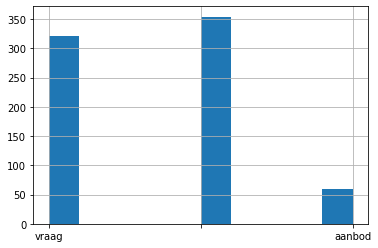

In [11]:
df_result['label'].hist()

## Classificatie

In [12]:

vectoriser = TfidfVectorizer()
df_result['vectors'] = list(vectoriser.fit_transform(df_result['stemmed']).toarray())


In [13]:
df_train = df_result[df_result['label'] != ""].copy()
df_predict = df_result[df_result['label'] == ""].copy()

In [14]:
enc = LabelEncoder()
encoded_labels = enc.fit_transform(df_train['label'])
enc.classes_

array(['aanbod', 'vraag'], dtype=object)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_train['vectors'].to_list(), encoded_labels, test_size=0.2)

In [16]:
# model = DecisionTreeClassifier()
model = LinearSVC()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [17]:
model.score(X_test, y_test)

0.9090909090909091

Word2Vec

## Topic modelling

https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21

In [18]:
text_data = df_result['lemma']
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [19]:

# 5 topics
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=30)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=7)
for topic in topics:
    print(topic)

(0, '0.034*"mens" + 0.021*"hulp" + 0.012*"boodschap" + 0.012*"tijd" + 0.012*"vrijwilliger" + 0.011*"contact" + 0.011*"corona"')
(1, '0.019*"boodschap" + 0.018*"hulp" + 0.014*"oud" + 0.014*"nodig" + 0.011*"moeder" + 0.011*"tijd" + 0.010*"graag"')
(2, '0.024*"oud" + 0.023*"bewoner" + 0.021*"kaart" + 0.013*"mooi" + 0.011*"mens" + 0.011*"leuk" + 0.010*"bezoek"')
(3, '0.010*"kaart" + 0.009*"oud" + 0.009*"mens" + 0.008*"mondkapje" + 0.008*"functie" + 0.008*"omschrijving" + 0.006*"leuk"')
(4, '0.054*"none" + 0.032*"functie" + 0.031*"omschrijving" + 0.022*"vrijwilliger" + 0.009*"mens" + 0.007*"maaltijd" + 0.006*"leuk"')


In [20]:
# three topics
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 3, id2word=dictionary, passes=15)
ldamodel.save('model3.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.025*"mens" + 0.012*"leuk" + 0.010*"hulp" + 0.009*"functie"')
(1, '0.019*"oud" + 0.018*"hulp" + 0.015*"mens" + 0.013*"boodschap"')
(2, '0.030*"none" + 0.015*"vrijwilliger" + 0.015*"tijd" + 0.013*"oud"')


In [28]:
# 10 topics
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 10, id2word=dictionary, passes=15)
ldamodel.save('model10.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.022*"vrijwilliger" + 0.017*"corona" + 0.017*"graag" + 0.016*"week"')
(1, '0.120*"none" + 0.011*"vrijwilliger" + 0.010*"omschrijving" + 0.010*"functie"')
(2, '0.025*"mens" + 0.021*"kind" + 0.015*"functie" + 0.015*"leuk"')
(3, '0.034*"oud" + 0.022*"kaart" + 0.017*"mooi" + 0.015*"leuk"')
(4, '0.023*"vrijwilliger" + 0.013*"mondkapje" + 0.012*"boodschap" + 0.011*"jong"')
(5, '0.011*"oppas" + 0.010*"oud" + 0.010*"nodig" + 0.009*"zorg"')
(6, '0.030*"bewoner" + 0.024*"kaart" + 0.016*"tijd" + 0.014*"moeilijk"')
(7, '0.022*"mens" + 0.022*"maaltijd" + 0.016*"vrijwilliger" + 0.011*"omschrijving"')
(8, '0.036*"hulp" + 0.033*"mens" + 0.022*"boodschap" + 0.015*"oud"')
(9, '0.022*"mens" + 0.010*"tijd" + 0.009*"graag" + 0.009*"hulp"')


## TFIDF

In [24]:
encoded_labels_p= model.predict(df_predict['vectors'].to_list())
new_labels = enc.inverse_transform(encoded_labels_p)

cvec = CountVectorizer(min_df=.0025, max_df=.1, ngram_range=(1,2))
cvec.fit(df_result.stemmed)
cvec_counts = cvec.transform(df_result.stemmed)

print('sparse matrix shape:{}'.format(cvec_counts.shape))
print('nonzero count:{}'.format(cvec_counts.nnz))
print('sparsity: {}'.format(100.0 * cvec_counts.nnz / (cvec_counts.shape[0] * cvec_counts.shape[1])))

occ = np.asarray(cvec_counts.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'term': cvec.get_feature_names(), 'occurrences': occ})
counts_df.sort_values(by='occurrences', ascending=False).head(20)

sparse matrix shape:(735, 1408)
nonzero count:7345
sparsity: 0.7097441249226963


,term,occurrences
699,leuk,89
155,boodschap,85
458,graag,81
1327,week,71
220,contact,67
589,kaart,66
111,bewoner,65
616,kind,64
403,functie omschrijving,64
874,nodig,63


In [27]:
tvec = TfidfVectorizer(min_df=.0025, max_df=.1)
tvec_weights = tvec.fit_transform(df_result['stemmed'].dropna())
weights = np.asarray(tvec_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tvec.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)

,term,weight
99,boodschap,0.028069
283,graag,0.023286
502,nodig,0.021952
80,bewoner,0.020025
361,kind,0.019009
407,leuk,0.018519
781,week,0.018350
278,goed,0.016437
284,gratis,0.015673
337,jaar,0.015382
